# 正則化ありのロジスティック回帰

正則化ありのロジスティック回帰の例として，マイクロチップが品質保証テストを通るかどうか予測する問題を扱う．過去のマイクロチップに対する2つのテストの点数と合否を訓練データとして用いる．この例ではテストの点数の高さが必ずしも合格を意味しないことに注意されたい．

## データのロードと特徴量の定義

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [2]:
# 訓練データのロード
# 0列目：テスト1の点数，1列目：テスト2の点数，2列目：合否（合格が1，不合格が0）
data = np.loadtxt('data/ex2data2.txt',delimiter=',')
X_unext = np.array(data[:,0:-1]) # 特徴量を各チップについて縦に並べた行列
y = np.array(data[:,[-1]]) # ターゲットを各チップについて縦に並べた列ベクトル

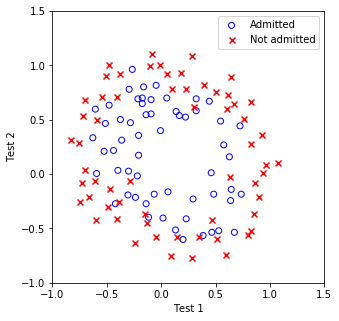

In [3]:
# 訓練データのプロット
I_y1 = (y == 1).flatten() # 合格チップの論理インデックス
I_y0 = (y == 0).flatten() # 不合格チップの論理インデックス
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax.set_xlim([-1,1.5])
ax.set_ylim([-1,1.5])
ax.set_xlabel('Test 1')
ax.set_ylabel('Test 2')
ax.legend()
ax.set_aspect('equal')

訓練データのプロットを見れば明らかなように，決定境界（合否の境界線）は線形ではない．したがって，ロジスティック回帰で用いるシグモイド関数の引数を，テストの点数の1次関数ではなく非線形項を含むものにしなければならない．ここではテスト1, 2の点数$x_1$, $x_2$の6次までの冪 ($(x_1)^p (x_2)^q$ ($0\leq p+q\leq 6$) を特徴量として用いる．

In [4]:
# x_1, x_2の6次までの冪を特徴量とする
def mapFeature(X_unext):
    P = 6;
    X1 = X_unext[:,0]
    X2 = X_unext[:,1]
    m = X1.size
    n = int((P+1)*(P+2)/2 - 1)
    X = np.ones((m,n+1))
    
    k = 0
    for p in np.arange(P+1):
        for q in np.arange(p+1):
            X[:,k] = (X1**(p-q)) * (X2**q)
            k = k + 1
    
    return(X)

In [5]:
# 特徴量行列
X = mapFeature(X_unext)
m, n = X.shape
n = n - 1
print('訓練データの数：m =',m)
print('特徴量の数（0番目の特徴量は除く）：n =',n)

訓練データの数：m = 118
特徴量の数（0番目の特徴量は除く）：n = 27


## 仮説とコスト関数の定義

特徴量ベクトルを$x=(x_0 ,x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットを$y$とする．ただし，0番目の特徴量は常に$x_0 =1$とする．特徴量とターゲットの組$(x,y)$は何らかの真の分布$p(x,y)=p(x)p(y\vert x)$に従う．特徴量$x$が与えられたときのターゲット$y$の分布$p(y\vert x)$を推定したい．パラメータ$\theta =(\theta ^0 ,\theta ^1 ,\dots ,\theta ^n)^\mathrm{T}$に対して仮説を
$$
h_\theta (x)=\sigma (x^\mathrm{T} \theta ),\quad\sigma (z)=\frac{1}{1+e^{-z}}
$$
とする．ロジスティック回帰では，特徴量$x$が与えられたときターゲットが$y=1$となる確率$p(y=1\vert x,\theta )$が$h_\theta (x)$であると推定する．

コスト関数はターゲットの真の分布$p(x,y)$と推定される分布$p(x,y\vert\theta )$の交差エントロピーとする：
$$
J(\theta )=-\frac{1}{m} \sum _{d=1}^m [y^{(d)} \log h_\theta (x^{(d)})+(1-y^{(d)})\log (1-h_\theta (x^{(d)}))].
$$
ただし，$(d)$は$d=1,\dots ,m$番目のデータを表す．このとき，コスト関数の勾配は次のように表される：
$$
\frac{\partial J(\theta )}{\partial\theta ^i} =\frac{1}{m} \sum _{d=1}^m (h_\theta (x^{(d)})-y^{(d)})x_i^{(d)} .
$$

以下では正則化項をつけたコスト関数を用いて勾配法を実行する．次のような正則化項つきコスト関数を考えよう：
$$
J_\mathrm{r} (\theta )=J(\theta)+\frac{1}{2m} \sum _{i=0}^n \mu _i (\theta ^i)^2 .
$$
正則化項に含まれる$\mu =(\mu _0 ,\mu _1 ,\dots ,\mu _n)^\mathrm{T}$はハイパーパラメータである．このとき，コスト関数の勾配は次のように表される：
$$
\frac{\partial J_\mathrm{r} (\theta )}{\partial\theta ^i} =\frac{\partial J(\theta )}{\partial\theta ^i} +\frac{1}{m} \mu _i \theta ^i .
$$
最後の項で$i$に関する和はとらないことに注意されたい．

正則化パラメータは$\mu _0 =\mu _1 =\dots =\mu _n$もしくは$\mu _0 =0$, $\mu _1 =\dots =\mu _n$のようにとることが多い．以下では主に後者の場合を考える．

In [6]:
# シグモイド関数
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return(s)

In [7]:
# コスト関数（正則化項なし）と勾配
def costFunction_gradient(X,y,theta):
    epsilon = 1e-7 # np.log(0) の発散を防ぐ
    m = y.size
    h = sigmoid(X @ theta)
    J = -(1 / m) * np.squeeze((y.T @ np.log(h+epsilon) + (1-y).T @ np.log(1-h+epsilon)))
    J_theta = (1 / m) * X.T @ (h - y)
    return(J,J_theta)

In [8]:
# 正則化項つきコスト関数と勾配
def costFunctionReg_gradient(X,y,theta,mu):
    m = y.size
    J, J_theta = costFunction_gradient(X,y,theta)
    Jr = J + (1 / (2 * m)) * np.squeeze(np.sum(mu * theta**2, axis=0))
    Jr_theta = J_theta + (1 / m) * mu * theta
    return(Jr,Jr_theta)

In [9]:
# 正則化パラメータ
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0

In [10]:
# 初期パラメータでコスト関数を評価
thetai = np.zeros((n+1,1)) # 初期パラメータ（ゼロベクトル）
Jri, _ = costFunctionReg_gradient(X,y,thetai,mu)
print(Jri)

0.6931469805599654


## 勾配法

勾配法では，コスト関数の勾配と逆方向にパラメータを動かすことでコスト関数の最小点を探索する．正則化あり勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha\frac{\partial J_\mathrm{r} (\theta )}{\partial\theta} .
$$
$\alpha$は学習率と呼ばれる．正則化項は（0番目以外の）特徴量を小さくする効果を持つ．

In [11]:
# 正則化あり勾配法
def gradientDescentReg(X,y,thetai,mu,alpha=0.1,num_iters=10000):
    theta = thetai
    Jr_theta = 0
    theta_history = np.zeros((theta.size,num_iters+1))
    Jr_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * Jr_theta
        theta_history[:,[i]] = theta
        Jr_history[i], Jr_theta = costFunctionReg_gradient(X,y,theta,mu)
    
    return(theta,theta_history,Jr_history)

学習率$\alpha =0.1$，正則化パラメータ$\mu =(0,1,\dots ,1)^\mathrm{T}$で勾配法を実行すると，更新回数10,000程度でコストとパラメータが収束することがわかる．

パラメータ theta = [ 1.27272613  0.62526689  1.18107972 -2.01992953 -0.91739446 -1.43161597
  0.12401476 -0.36554101 -0.35726032 -0.17511341 -1.45816817 -0.05101463
 -0.61556909 -0.27469994 -1.19282176 -0.24218133 -0.20601527 -0.04475642
 -0.27778226 -0.29538169 -0.45637255 -1.04321703  0.02775375 -0.29244207
  0.01555143 -0.32738437 -0.14388382 -0.92468468]


Text(0, 0.5, 'Parameters')

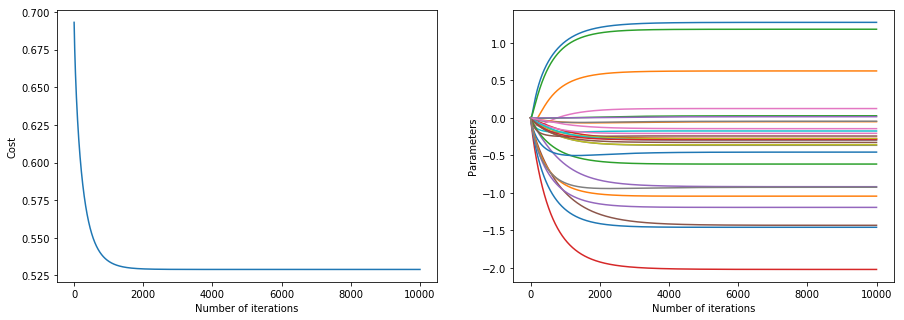

In [12]:
# 正則化あり勾配法の実行
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu)
print('パラメータ theta =',theta.flatten())

# パラメータ更新ごとの正則化項つきコスト，パラメータをプロット
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = fig.add_subplot(122)
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')

学習率を大きくして$\alpha =3$としても正則化あり勾配法は収束する．この場合更新回数は250程度でよい．

パラメータ theta = [ 1.2726053   0.62521642  1.18101362 -2.01969872 -0.91715742 -1.43118924
  0.12406527 -0.36559138 -0.35740795 -0.17501046 -1.45822109 -0.05120184
 -0.61562903 -0.27464609 -1.19284143 -0.24212873 -0.20609212 -0.0449339
 -0.27775634 -0.29540274 -0.45652113 -1.04329758  0.02761554 -0.29250083
  0.01544228 -0.32740297 -0.14385486 -0.92494255]


Text(0, 0.5, 'Parameters')

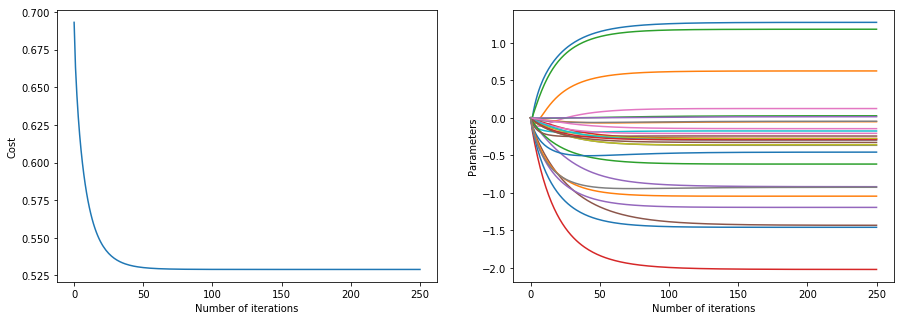

In [13]:
# 正則化あり勾配法の実行
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=3,num_iters=250)
print('パラメータ theta =',theta.flatten())

# パラメータ更新ごとの正則化項つきコスト，パラメータをプロット
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = fig.add_subplot(122)
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')

では学習率$\alpha =3$，正則化パラメータ$\mu =(0,1,\dots ,1)^\mathrm{T}$の勾配法について，訓練データに対する正解率の履歴，および最終的に得られたパラメータから決まる決定境界をプロットしてみよう．訓練データに対する正解率は約83%に収束していることがわかる．決定境界は合格チップと不合格チップを概ね正しく分けており，境界線の形も複雑すぎず過学習が起きていないため，悪くない結果だと言える．

In [14]:
# 予測
def predict(X,theta):
    h = sigmoid(X @ theta)
    yp = np.minimum(np.floor(2*h),1)
    return(yp)

In [15]:
# 予測と正解率
def predict_accuracy(X,y,theta):
    m = y.size
    yp = predict(X,theta)
    I_True = (yp == y).astype('float')
    acc = np.sum(I_True,axis=0) / m
    return(yp,acc)

訓練データに対する正解率 0.8305084745762712


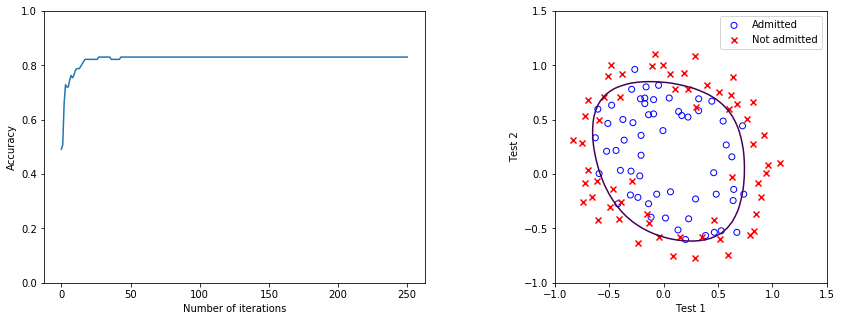

In [16]:
# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# 正解率の推移と最終的な決定境界をプロット
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(acc_history)
ax1.set_ylim([0,1])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax2 = fig.add_subplot(122)
ax2.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax2.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax2.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax2.set_xlim([-1,1.5])
ax2.set_ylim([-1,1.5])
ax2.set_xlabel('Test 1')
ax2.set_ylabel('Test 2')
ax2.legend()
ax2.set_aspect('equal')

## 正則化パラメータの調整

上記では正則化パラメータを$\mu =(0,1,\dots ,1)^\mathrm{T}$としたが，この値を調整すると結果はどのように変わるだろうか．

まずは正則化項なし，すなわち$\mu =0$の場合を計算してみよう．学習率をなるべく限界まで上げて$\alpha =10$とし，更新回数$10^5$で勾配法を実行すると，コストは収束しているようにも見えるがパラメータは収束していない．勾配法は収束していないが試しに訓練データに対する正解率の推移と決定境界をプロットしてみると，正解率は約87%と高い一方で決定境界の形が複雑であり，過学習が起きていると言える．

パラメータ theta = [  2.71168543  -1.3806876    1.74788466 -11.77729302  -8.60624833
   8.25560587   3.11592695  20.69883227  33.77176723   6.62289405
  46.7234592    9.20041147 -13.65525756  -8.56788095 -40.4700614
  12.20519793  -8.82681684  -6.39175961 -16.30715963 -21.30177601
  12.28773425 -80.78391288 -41.22799526  -7.94838505  31.79715691
 -60.22244558 -40.88168078   3.05413789]
訓練データに対する正解率 0.8728813559322034


/Users/kabukitakada/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


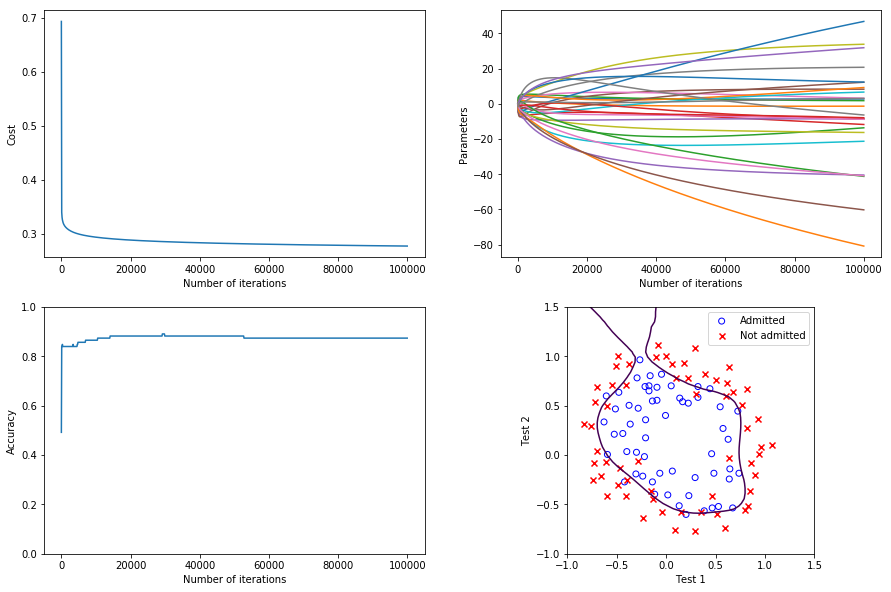

In [17]:
# 正則化なし勾配法の実行
mu = np.zeros((n+1,1))
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=10,num_iters=int(1e+5))
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新100回ごとのコスト，パラメータ，正解率と決定境界をプロット
t = np.arange(0,Jr_history.size+1,100)
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t,Jr_history[t])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(t,theta_history[:,t].T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(t,acc_history[t])
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

パラメータ theta = [   5.24400791    1.92305332    3.16100567  -44.43946233  -15.4300551
   -5.84350809  -21.17230253   12.6816656    29.11387809    1.00731785
  159.91823158   63.26701736   88.74728934   12.08325671  -13.88507921
   52.15718732   -1.5827537   -26.61119164  -28.1146814    -5.91696943
   24.95321832 -199.82944518 -117.81028577 -107.17735038   30.49198724
 -142.69207066  -83.01630868  -21.79454637]
訓練データに対する正解率 0.8728813559322034


/Users/kabukitakada/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


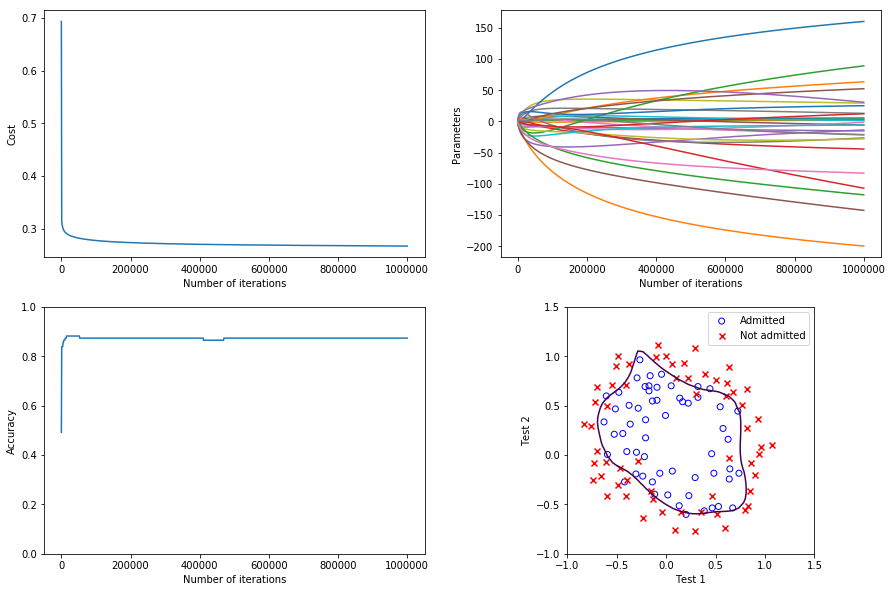

In [18]:
# 正則化なし勾配法の実行
mu = np.zeros((n+1,1))
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=10,num_iters=int(1e+6))
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新1000回ごとのコスト，パラメータ，正解率と決定境界をプロット
t = np.arange(0,Jr_history.size+1,1000)
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t,Jr_history[t])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(t,theta_history[:,t].T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(t,acc_history[t])
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

逆に正則化項を大きくして$\mu =(0,10,\dots ,10)^\mathrm{T}$とすると，訓練データに対する正解率は約75%に下がり，決定境界は左下に寄る．したがって，この正則化パラメータは大きすぎると言える．

パラメータ theta = [ 0.32617739 -0.00815037  0.16579737 -0.44671794 -0.11177303 -0.27891553
 -0.07145283 -0.05789005 -0.06509879 -0.10636962 -0.33672906 -0.01297379
 -0.1167069  -0.02809801 -0.28602589 -0.11614863 -0.03704603 -0.02242244
 -0.04886563 -0.0416313  -0.18675657 -0.25333941 -0.00291262 -0.05796666
 -0.00052915 -0.06352868 -0.01206585 -0.27148712]
訓練データに対する正解率 0.7457627118644068


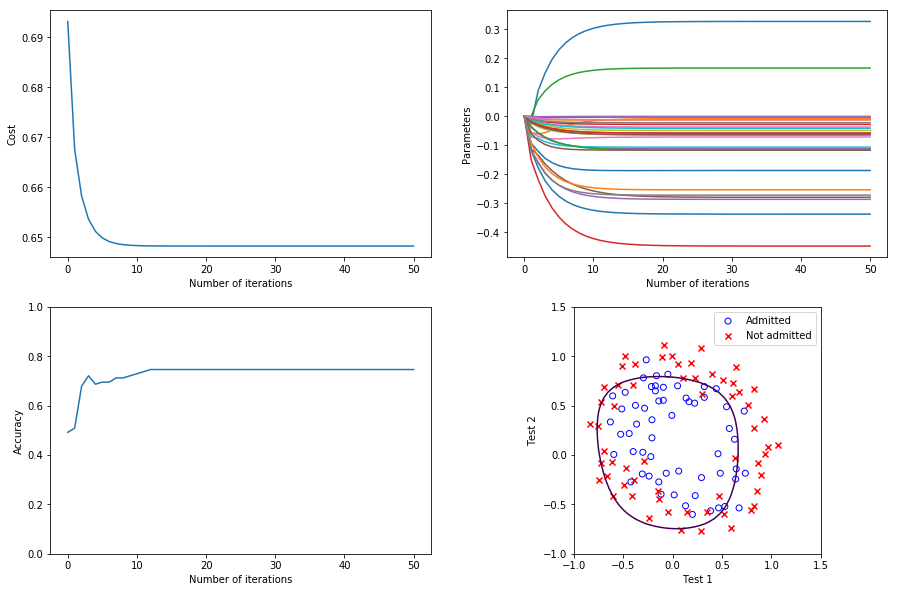

In [19]:
# 正則化あり勾配法の実行
mu1 = 10
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=3,num_iters=50)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

正則化パラメータをさらに大きくして$\mu =(0,100,\dots ,100)^\mathrm{T}$とすると，訓練データに対する正解率は約61%に下がり，決定境界はかなり左下寄りになる．

パラメータ theta = [ 0.0218776  -0.01748171  0.0057108  -0.05516894 -0.01314877 -0.03859857
 -0.01846356 -0.00773219 -0.00892429 -0.02280452 -0.04343846 -0.00235623
 -0.01415612 -0.00349508 -0.04143587 -0.02100593 -0.00471917 -0.00359131
 -0.00632226 -0.0050244  -0.03197675 -0.03416334 -0.00107629 -0.00702615
 -0.00038506 -0.0079823  -0.00154779 -0.04108676]
訓練データに対する正解率 0.6101694915254238


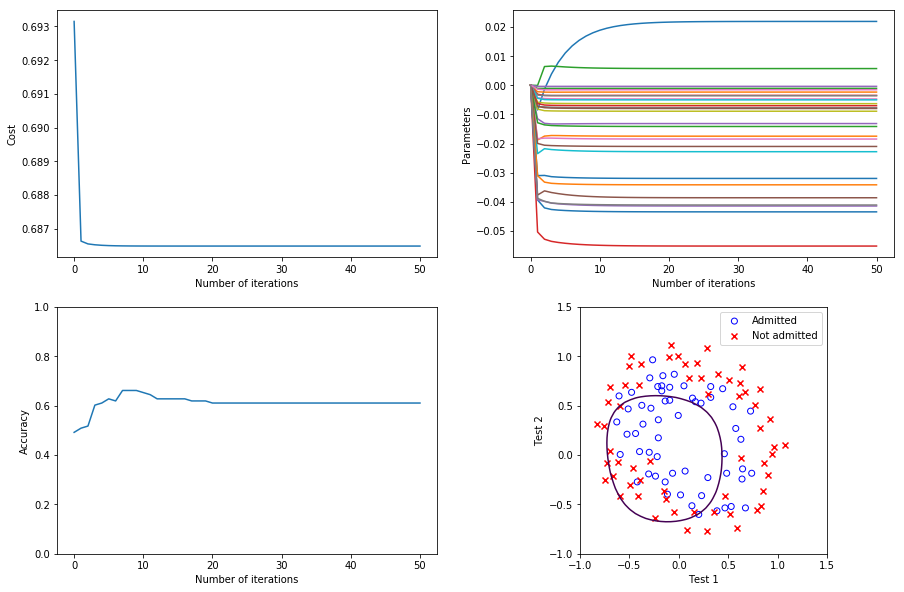

In [20]:
# 正則化あり勾配法の実行
mu1 = 100
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=1,num_iters=50)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

次に，0番目のパラメータにも正則化を施した場合を考えよう．まず$\mu =(1,1,\dots ,1)^\mathrm{T}$とすると，$\mu =(0,1,\dots ,1)^\mathrm{T}$だったときと比べてほとんどパフォーマンスの違いはない．

パラメータ theta = [ 1.14208897  0.6013098   1.16713684 -1.87172074 -0.91550143 -1.26932939
  0.12668152 -0.36874104 -0.34531442 -0.1736892  -1.42383629 -0.04879678
 -0.60637294 -0.26929643 -1.16310512 -0.24304693 -0.20714096 -0.04335648
 -0.28021629 -0.28695891 -0.46924513 -1.03617146  0.02906028 -0.29262055
  0.01722843 -0.32892423 -0.13795118 -0.93216803]
訓練データに対する正解率 0.8220338983050848


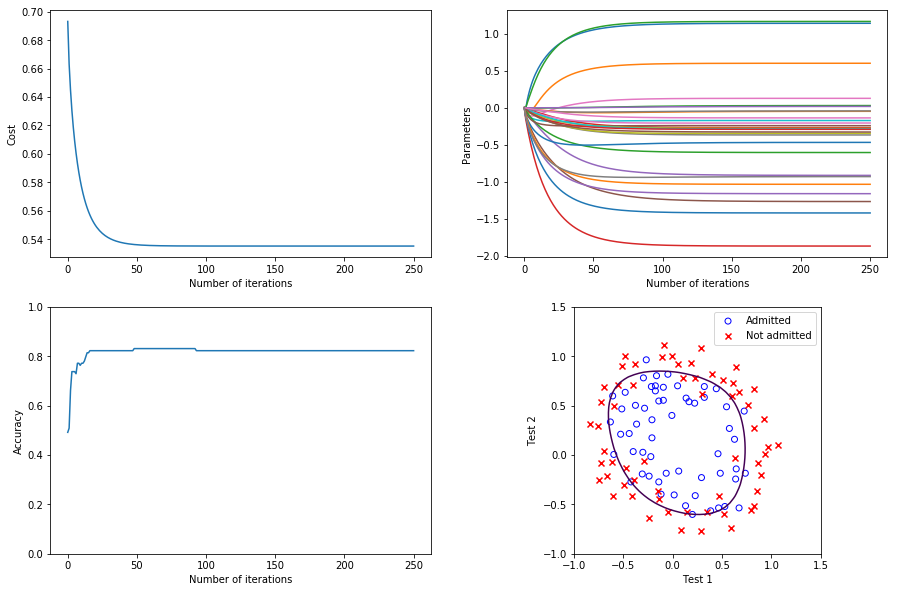

In [21]:
# 正則化あり勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=3,num_iters=250)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

正則化項を大きくして$\mu =(10,10,\dots ,10)^\mathrm{T}$としても，$\mu =(0,10,\dots ,10)^\mathrm{T}$のときと比べてパフォーマンスの違いはほぼ見られない．

パラメータ theta = [ 0.2147137  -0.00759417  0.17609631 -0.40128041 -0.1174486  -0.23187719
 -0.06667995 -0.05584258 -0.06214433 -0.09712316 -0.31766635 -0.01468065
 -0.10912918 -0.03014286 -0.26765328 -0.11186997 -0.03627426 -0.02114481
 -0.04753649 -0.04037679 -0.1812024  -0.24308858 -0.00364209 -0.05525124
 -0.00101445 -0.06093904 -0.01293853 -0.26289809]
訓練データに対する正解率 0.7457627118644068


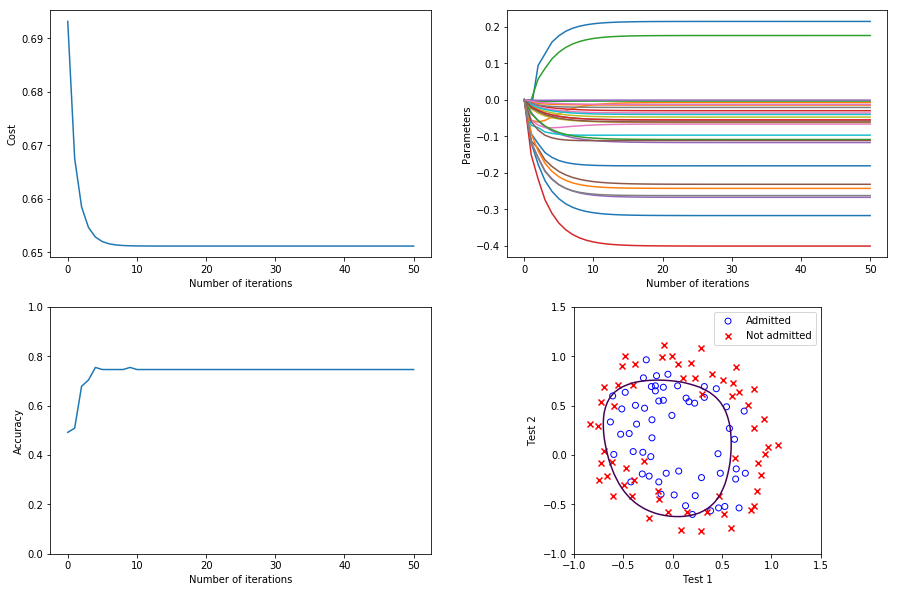

In [22]:
# 正則化あり勾配法の実行
mu1 = 10
mu = mu1 * np.ones((n+1,1))
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=3,num_iters=50)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

しかし，正則化項をさらに大きくして$\mu =(100,100,\dots ,100)^\mathrm{T}$とすると，$\mu =(0,100,\dots ,100)^\mathrm{T}$のときと比べて決定境界の直径がかなり小さくなっている．したがって，0番目のパラメータにも正則化を施した場合，正則化項を大きくしたときに決定境界の直径が小さくなりやすくなると言える．

パラメータ theta = [ 0.0046864  -0.01726853  0.00641956 -0.05402667 -0.01327561 -0.03727153
 -0.01821193 -0.00761041 -0.00885311 -0.02224572 -0.04288367 -0.00238586
 -0.01393199 -0.00354831 -0.04072376 -0.02078573 -0.00467204 -0.00354979
 -0.00624896 -0.00500396 -0.03153153 -0.03381512 -0.00108319 -0.00694194
 -0.0003945  -0.00788597 -0.00157685 -0.04058852]
訓練データに対する正解率 0.6016949152542372


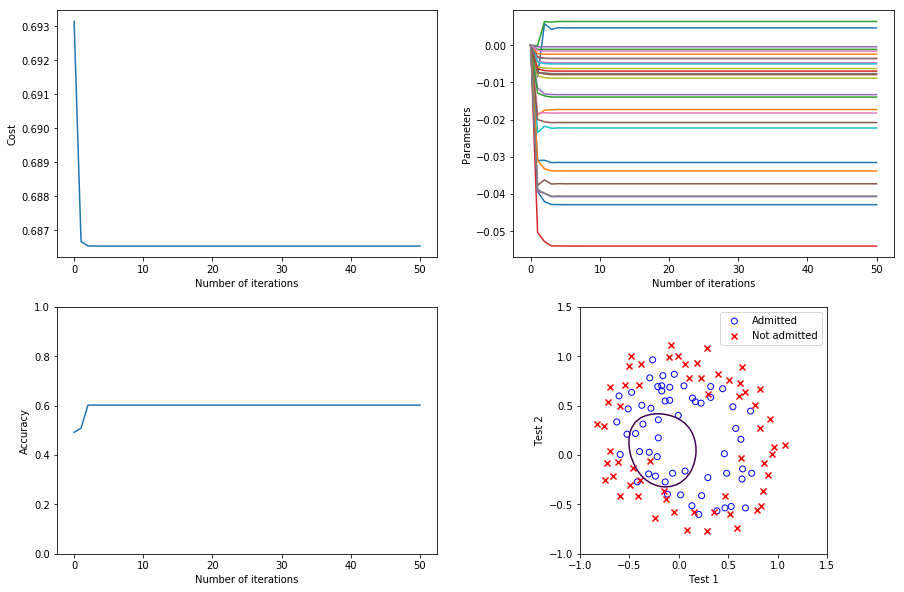

In [23]:
# 正則化あり勾配法の実行
mu1 = 100
mu = mu1 * np.ones((n+1,1))
theta, theta_history, Jr_history = gradientDescentReg(X,y,thetai,mu,alpha=1,num_iters=50)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

## 自然勾配法

次に自然勾配法を実行しよう．正則化つきコスト関数$J_\mathrm{r} (\theta )$の勾配にFisher情報行列$g$の逆行列をかけたものに比例してパラメータを減らしていくことにすると，次の更新式が得られる：
$$
\theta\leftarrow\theta -\alpha g^{-1} \frac{\partial J_\mathrm{r} (\theta )}{\partial\theta} .
$$
ここで，Fisher情報行列$g(\theta )$の$(i,j)$成分は次のように与えられる：
$$
g_{ij} (\theta )=\frac{1}{m} \sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x_i^{(d)} x_j^{(d)} .
$$

In [24]:
# Fisher情報行列
def FisherMatrix(X,theta):
    m = X.shape[0]
    h = sigmoid(X @ theta)
    h_d1 = h * (1 - h)
    g = (1 / m) * np.einsum('dt,di,dj->tij',h_d1,X,X)
    return(g)

In [25]:
# 正則化あり自然勾配法
def naturalGradientDescentReg1(X,y,thetai,mu,alpha=0.1,num_iters=200):
    theta = thetai
    Jr_theta_n = 0
    theta_history = np.zeros((theta.size,num_iters+1))
    Jr_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * Jr_theta_n
        theta_history[:,[i]] = theta
        Jr_history[i], Jr_theta = costFunctionReg_gradient(X,y,theta,mu)
        g_inv = np.linalg.inv(FisherMatrix(X,theta))
        Jr_theta_n = np.einsum('tij,jt->it',g_inv,Jr_theta)
    
    return(theta,theta_history,Jr_history)

まずは正則化項なし ($\mu =0$) で自然勾配法を実行する．学習率を$\alpha =1$とすると，更新回数20回程度で収束する．訓練データに対する正解率は約89%と高いが，決定境界を見ると明らかに過学習が起きている．

パラメータ theta = [   38.23084759    55.59583326    98.14666683  -369.43019289
  -177.12043925  -194.26060039  -366.00867873  -842.21085851
  -719.44825491  -511.89459699  1182.70182173  1279.3433994
  1907.90024001   914.31908008   514.2802414    573.22321934
  1629.75119869  2553.60414847  2919.06697705  1780.60833197
   785.31506359 -1257.91315925 -2260.00530686 -4142.79598292
 -4290.59284092 -4229.65126307 -2055.54849176  -750.3814762 ]
訓練データに対する正解率 0.8898305084745762


/Users/kabukitakada/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


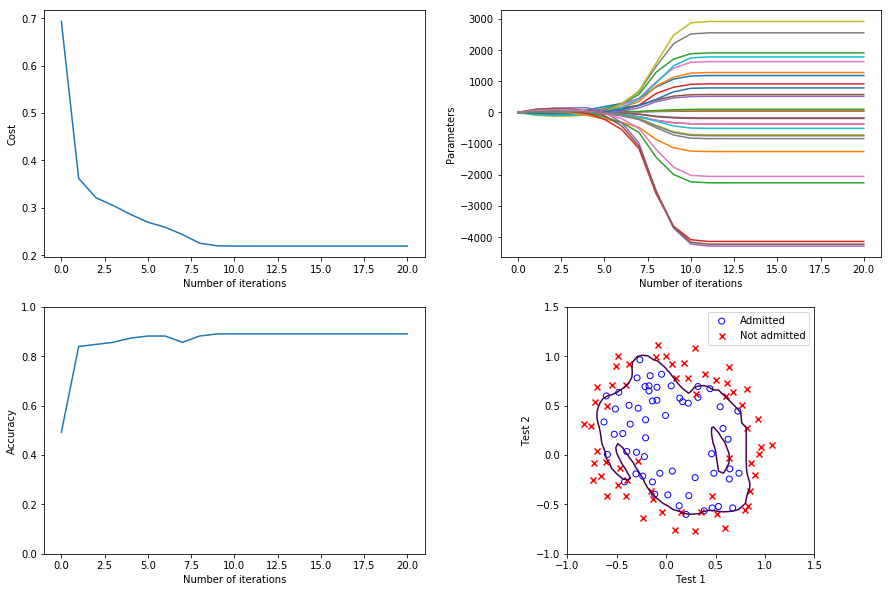

In [26]:
# 正則化なし自然勾配法の実行
mu = np.zeros((n+1,1))
theta, theta_history, Jr_history = naturalGradientDescentReg1(X,y,thetai,mu,alpha=1,num_iters=20)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

正則化なしでは過学習が起きるので，正則化パラメータを$\mu =(0,1,\dots ,1)$としてコスト関数に正則化項を加える．しかし，自然勾配法の効率は著しく悪いことがわかる．実際，学習率が$\alpha =3\times 10^{-4}$のときコストとパラメータは発散し，$\alpha =1\times 10^{-4}$のときパラメータは振動する．$\alpha =3\times 10^{-5}$とすると，200,000ステップ程度かけてようやくコストとパラメータが収束する．

/Users/kabukitakada/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


パラメータ theta = [-1.07815841e+14  4.08586052e+14  1.72830655e+14 -4.36907262e+13
 -2.76580307e+14  1.45093374e+14 -2.34640747e+14  1.12618084e+14
  2.00787011e+13  2.87766759e+13 -2.38164429e+14  1.15004716e+14
 -3.10768808e+13 -4.66118065e+13  5.59548137e+13 -2.50884768e+14
  1.57138979e+14 -9.19335538e+13  5.38865439e+13 -2.01139842e+13
  1.99411330e+13 -2.16055478e+14  1.37476508e+14 -8.28457268e+13
  4.27341201e+13 -1.67327554e+13 -5.17834106e+12  1.46590788e+13]
訓練データに対する正解率 0.5254237288135594


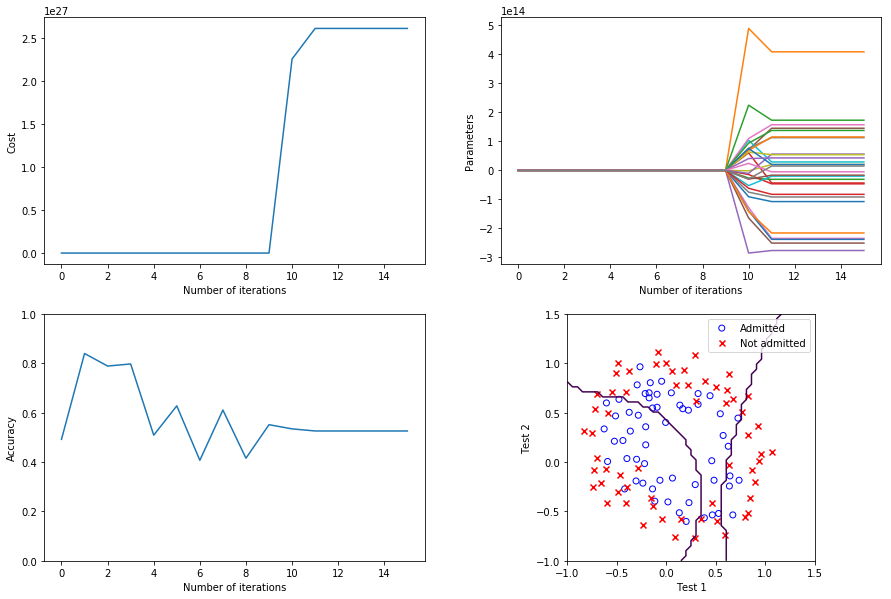

In [27]:
# 正則化あり自然勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = naturalGradientDescentReg1(X,y,thetai,mu,alpha=3e-4,num_iters=15)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

パラメータ theta = [ 0.66482433  0.25395272  0.42632392 -0.78194192 -0.44052903 -0.6324838
  0.40913796  0.64425894  0.8737522   0.9110127  -1.64717533 -0.20551257
 -1.77888775 -0.48525519 -1.37510274 -0.69570836 -1.26037138 -2.000403
 -2.55856633 -1.78840653 -0.96358434 -0.36642207  0.77280577  2.15764804
  2.23587286  2.58410607  1.33935215  0.08594174]
訓練データに対する正解率 0.8220338983050848


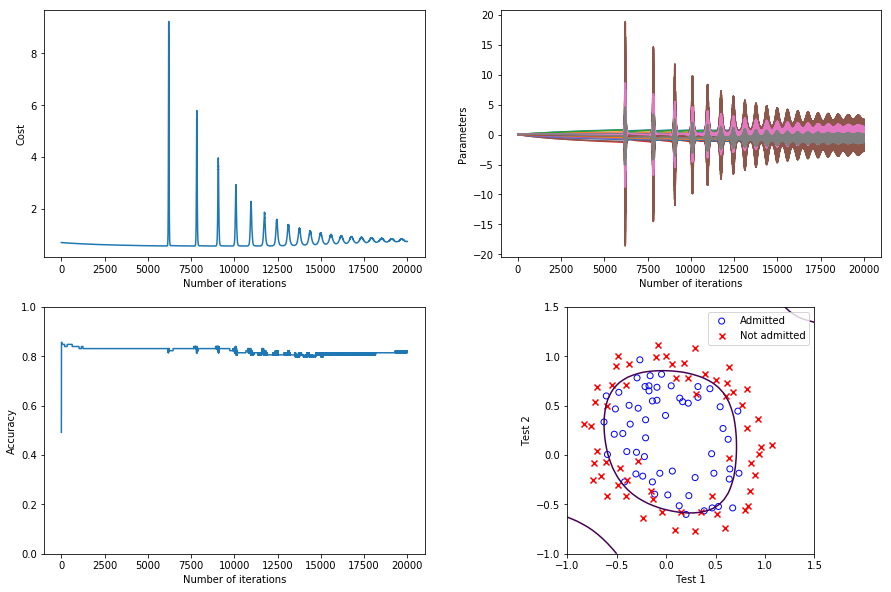

In [28]:
# 正則化あり自然勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = naturalGradientDescentReg1(X,y,thetai,mu,alpha=1e-4,num_iters=20000)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

パラメータ theta = [ 1.27245508  0.62597109  1.18152239 -2.01975973 -0.91747628 -1.43135417
  0.12437175 -0.36550744 -0.35718026 -0.17481107 -1.45798289 -0.05100326
 -0.61548541 -0.27473769 -1.19253232 -0.24195665 -0.20600704 -0.04469154
 -0.27775612 -0.29538454 -0.45608637 -1.04306201  0.02776594 -0.29239978
  0.01556125 -0.32733973 -0.14391662 -0.92439942]
訓練データに対する正解率 0.8305084745762712


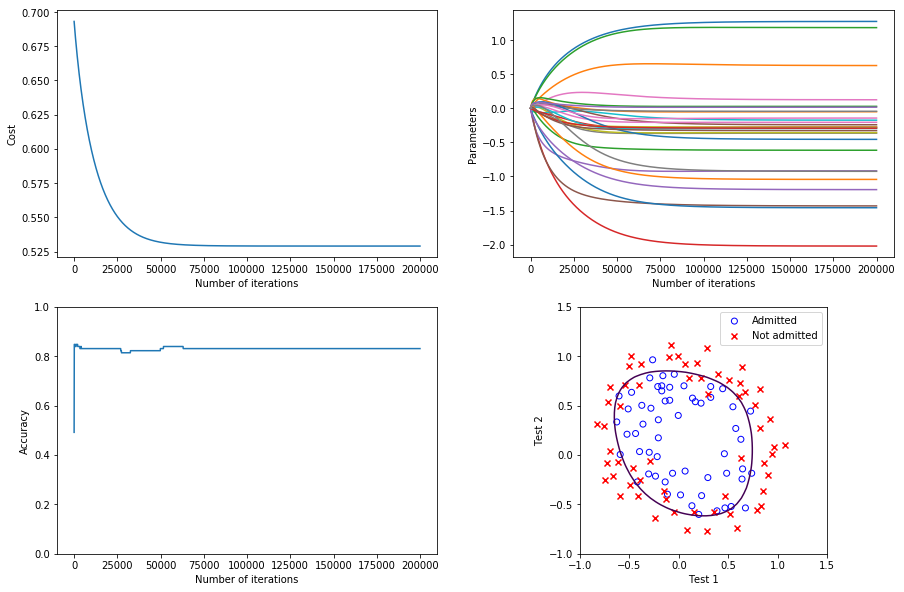

In [29]:
# 正則化あり自然勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = naturalGradientDescentReg1(X,y,thetai,mu,alpha=3e-5,num_iters=200000)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新100回ごとのコスト，パラメータ，正解率と決定境界をプロット
t = np.arange(0,Jr_history.size+1,100)
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(t,Jr_history[t])
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(t,theta_history[:,t].T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(t,acc_history[t])
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

このように自然勾配法の効率が悪くなったのは，コスト関数だけ正則化してFisher情報行列を正則化しなかったためだと考えられる．そこで，今度はFisher情報行列も正則化する．もともと正則化していなかったときは$g_{ij} (\theta )=\partial _i \partial _j J(\theta )$が成り立っていたことに注目して，正則化したFisher情報行列を次のように定義する：
$$
(g_\mathrm{r})_{ij} (\theta )=\partial _i \partial _j J_\mathrm{r} (\theta )=g_{ij} (\theta )+\frac{1}{m} \mu _i \delta _{ij} .
$$
ここで$\delta ^{ij}$はKroneckerのデルタである．新しい自然勾配法の更新式は
$$
\theta\leftarrow\theta -\alpha g_\mathrm{r}^{-1} \frac{\partial J_\mathrm{r} (\theta )}{\partial\theta}
$$
となる．

In [30]:
# 正則化項つきFisher情報行列
def FisherMatrixReg(X,theta,mu):
    m = X.shape[0]
    T = theta.shape[1]
    g = FisherMatrix(X,theta)
    gr = g + (1 / m) * np.tile(np.diag(mu.flatten()),(T,1,1))
    return(gr)

In [31]:
# 正則化あり自然勾配法（Fisher情報行列も正則化）
def naturalGradientDescentReg2(X,y,thetai,mu,alpha=0.1,num_iters=200):
    theta = thetai
    Jr_theta_n = 0
    theta_history = np.zeros((theta.size,num_iters+1))
    Jr_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * Jr_theta_n
        theta_history[:,[i]] = theta
        Jr_history[i], Jr_theta = costFunctionReg_gradient(X,y,theta,mu)
        g_inv = np.linalg.inv(FisherMatrixReg(X,theta,mu))
        Jr_theta_n = np.einsum('tij,jt->it',g_inv,Jr_theta)
    
    return(theta,theta_history,Jr_history)

コスト関数とFisher情報行列を共に正則化した自然勾配法を実行すると，正則化パラメータが$\mu =(0,1,\dots ,1)$のとき，学習率$\alpha =0.1$では100ステップ程度で収束し，$\alpha =1$ではわずか5ステップで収束する．得られたパラメータや正解率の値は勾配法の場合と矛盾のない結果になっており，決定境界を見ると過学習が起きていないことがわかる．

パラメータ theta = [ 1.27269896  0.6252519   1.18104966 -2.01989753 -0.91739496 -1.43162477
  0.124009   -0.36552128 -0.3572273  -0.17512072 -1.4581042  -0.05098454
 -0.61553795 -0.27469429 -1.19277322 -0.24216955 -0.20599702 -0.04472923
 -0.27777571 -0.29536506 -0.45632967 -1.04315784  0.02777406 -0.29242301
  0.01556765 -0.32736948 -0.14387749 -0.92460697]
訓練データに対する正解率 0.8305084745762712


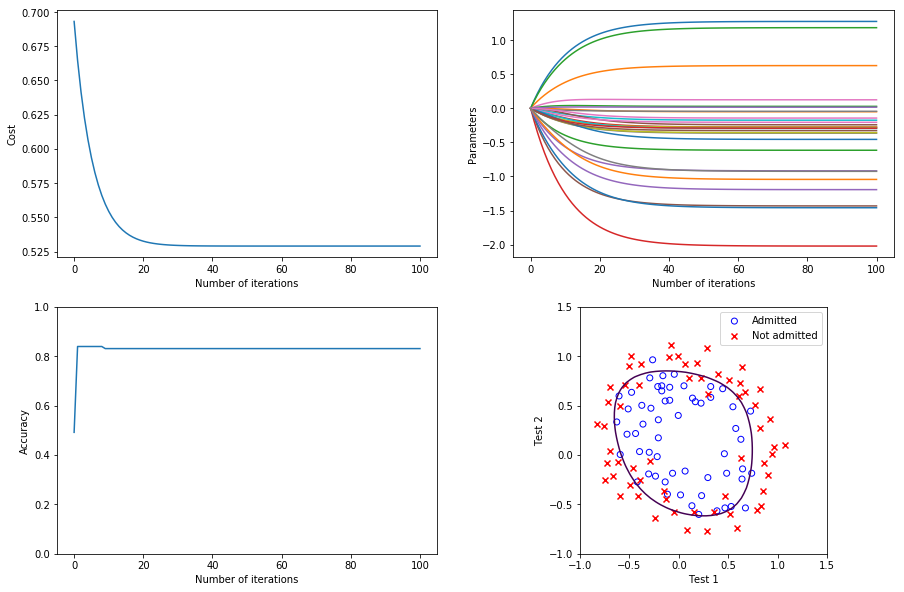

In [32]:
# 正則化あり自然勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = naturalGradientDescentReg2(X,y,thetai,mu,alpha=0.1,num_iters=100)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')

パラメータ theta = [ 1.27273951  0.6252718   1.18108869 -2.01996086 -0.91742375 -1.43166444
  0.12400635 -0.36553437 -0.35723962 -0.17513048 -1.45815646 -0.05098906
 -0.61555504 -0.27470631 -1.19281652 -0.24218823 -0.20600609 -0.04473075
 -0.2777845  -0.2953781  -0.45635749 -1.04320249  0.02777171 -0.29243131
  0.01556681 -0.32737959 -0.14388693 -0.92465257]
訓練データに対する正解率 0.8305084745762712


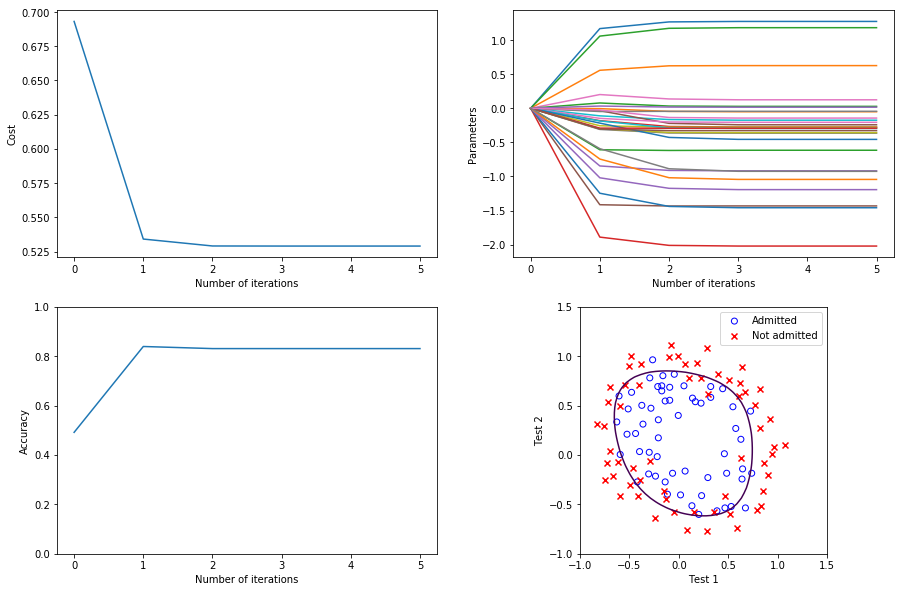

In [36]:
# 正則化あり自然勾配法の実行
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0
theta, theta_history, Jr_history = naturalGradientDescentReg2(X,y,thetai,mu,alpha=1,num_iters=5)
print('パラメータ theta =',theta.flatten())

# 訓練データに対する正解率
_, acc_history = predict_accuracy(X,y,theta_history)
print('訓練データに対する正解率',acc_history[-1])

# 特徴量の格子点上で仮説の値を計算
x1v = np.linspace(-1,1.5)
x2v = np.linspace(-1,1.5)
x1g, x2g = np.meshgrid(x1v,x2v)
hg = sigmoid(mapFeature(np.array([x1g.reshape(-1),x2g.reshape(-1)]).T) @ theta).reshape(x1g.shape)

# パラメータ更新ごとの正則化項つきコスト，パラメータ，正解率と決定境界をプロット
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,2)
ax1 = plt.subplot(gs[0,0])
ax1.plot(Jr_history)
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Cost')
ax2 = plt.subplot(gs[0,1])
ax2.plot(theta_history.T)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Parameters')
ax3 = plt.subplot(gs[1,0])
ax3.plot(acc_history)
ax3.set_ylim([0,1])
ax3.set_xlabel('Number of iterations')
ax3.set_ylabel('Accuracy')
ax4 = plt.subplot(gs[1,1])
ax4.scatter(X_unext[I_y1,0],X_unext[I_y1,1],marker='o',facecolors='none', edgecolors='b',label='Admitted')
ax4.scatter(X_unext[I_y0,0],X_unext[I_y0,1],marker='x',color='r',label='Not admitted')
ax4.contour(x1g,x2g,hg,levels=np.array([0.5]))
ax4.set_xlim([-1,1.5])
ax4.set_ylim([-1,1.5])
ax4.set_xlabel('Test 1')
ax4.set_ylabel('Test 2')
ax4.legend()
ax4.set_aspect('equal')